In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
%matplotlib inline


# RSM2310 - Fixed income securities
This notebook covers interpolation,bootstrapping,interpolation using Nelson Siegel model, and the implementation of the Vasicek model.

## Load data and pre process:
The csv file data.csv contains the historical rates for a set of trasury bonds.

In [2]:
def load_data():
    data = pd.read_csv('data.csv')
    data = data.set_index('Time Period')

    NDs=[]
    count =0
    for i in data.index:
        if 'ND'== data.loc[i][1]:
            NDs.append(i)
            count += 1
    print("Excluded {} NDs".format(count))
    print("{}% of the total".format(100*round(count/data.shape[0],2)))
    data_ = data.applymap(f).copy()
    data_ = data_[data_['RIFLGFCM06_N.B']>0] # keeping only data with at least one strip
    data_ = data_.loc['7/31/2001':]
    return data,data_

In [3]:
def f(x):
    try:
        return float(x)/100
    except:
        return np.nan

In [4]:
data,data_ = load_data()

Excluded 391 NDs
3.0% of the total


## Bootstrapping class:

In [8]:
'''
def fadjust(y,T):
    x = np.isnan(y)
    T_ = []
    y_ = []
    for i in np.arange(len(y)):
        if x[i]==False:
            T_.append(T[i])
            y_.append(y[i])
    return np.array(y_),np.array(T_)
    '''

def getStrips(y,T):
    rn = {}
    for i in np.arange(len(y)):
        if T[i]<0.5:
            rn[T[i]]=y[i]
    if len(rn.keys())==0:
        print("No strips retrieved!")
    return rn



In [20]:
class Bootstrapping():
    def __init__(self,F=100,cf=2):
        self.F = F
        self.cf = cf
        
    def getStrips(self,y,T):
        rn = {}
        for i in np.arange(len(y)):
            if T[i]<0.5:
                rn[T[i]]=y[i]
        if len(rn.keys())==0:
            print("No strips retrieved!")
        return rn
   
    def fadjust(self,y,T):
        x = np.isnan(y)
        T_ = []
        y_ = []
        for i in np.arange(len(y)):
            if x[i]==False:
                T_.append(T[i])
                y_.append(y[i])
        return np.array(y_),np.array(T_)
   
    def interpol(self,y,T_):
        self.y=y        
        self.T = np.arange(0.5,30.5,0.5)
        N = self.cf*self.T
        self.N = [int(x) for x in N]
        self.yn = np.interp(self.T,T_,y)
        self.rn = self.getStrips(y,T_) 
    
        
        if len(self.y)>4:      
            self.seed = [self.y[-1],self.y[0]-self.y[-1],self.y[1],self.y[2]]
        else:
            self.seed = [self.y[-1],self.y[0]-self.y[-1],self.y[1],self.y[2]]
    
    def get_price(self,y,T):
        C = y*self.F
        N = T*self.cf
        pv = 0
        for n in np.arange(N):
            pv += C/(1+y)**n
        pv += self.F/(1+y)**N
        return pv
    
    def solve(self,y,T_):      
        self.interpol(y,T_)
        for i in self.N:
            C = self.yn[i-2]*self.F/2
            rate_sum = self.get_price(self.yn[i-2],i/self.cf) 
            for j in np.arange(0.5,i/self.cf,0.5):
                rate_sum -= C*((1+self.rn[j]/self.cf)**(-j))
            self.rn[i/self.cf] = (((self.F+C)/rate_sum)**(1/i)-1)*2 
            
    def plot(self):
        d = pd.DataFrame.from_dict(self.rn,orient='index')
        d.plot(kind='scatter')

        

## Nelson Siegel Class

The Nelon Siegel model follow the equation:

\begin{equation}
R(0,t) = \beta_0 + \beta_1 \frac{1-e^{(\frac{-t}{T})}}{t/T} + \beta_2  (\frac{1-e^{(\frac{-t}{T})}}{t/T} -e^{\frac{-t}{T}})
\end{equation}

Where:

-  $R(0,t)$: pure discount rate with maturity t
-  $\beta_0$: level parameter, the long term rate
-  $\beta_1$: slope parameter, the spread short/long-term
-  $\beta_2$: curvature parameter
-  $T$: scale parameter



In [10]:
class NelsonSiegel():
    def __init__(self,rn):
        self.rn = rn
        
    def NS(self,w):
        rn = self.rn
        if type(self.rn)==dict:
            t = np.array(list(rn.keys()))
        else:
            t = self.rn

        A = [np.ones(t.shape[0]),(1-np.exp(-t/w[3]))/(t/w[3]),(1-np.exp(-t/w[3]))/(t/w[3])-np.exp(-t/w[3])]

        Ax = w[:3].dot(A)
        return Ax

    def loss(self,w):
        Ax = self.NS(w)
        rn = self.rn
        y = np.array(list(rn.values()))
        error = y - Ax
        Loss = np.sum(error**2)
        return Loss
    
    def get_w(self,x0):
        self.opt_results = optimize.minimize(self.loss,x0=x0,method='BFGS')
        return self.opt_results.x
    
    def plot_termS(self):
        termS = self.NS(self.opt_results.x)
        plt.plot(termS)
    

            

In [80]:
from scipy.interpolate import CubicSpline

class TermStructure(NelsonSiegel,Bootstrapping):
    def __init__(self):
        pass
    
    def Boot(self,y,T_,F=100,cf=2):
        self.F = F
        self.cf = cf
        self.solve(y,T_)
        
        
    def fitCubic(self,data_):
        cspline={}
        self.date = np.empty((0,1))
        count = 0
        num_of_days = 4000
        for day in data_.index[-num_of_days:]:
            T_ = [1/12,0.25,0.5,1,2,3,5,7,10,20,30]
            day1 = data_.loc[day]
            y = day1.as_matrix().flatten()
            y,T_ = self.fadjust(y,T_)
            rn = getStrips(y,T_)
            if rn.keys()==0:
                print('no rn?')
                continue
            self.Boot(y,T_)
            
            cspline[day1]= CubicSpline(T_,y)
            
            count +=1
            if count%100==0:
                print("Percent concluded: {}%".format(100*count/num_of_days))
        self.date = pd.to_datetime(self.date)
        self.Results = cspline
        
    
    def fitNS(self,data_):
        
        NScoef = np.empty((0,4))
        self.date = np.empty((0,1))
        count = 0
        num_of_days = 4000
        for day in data_.index[-num_of_days:]:
            T_ = [1/12,0.25,0.5,1,2,3,5,7,10,20,30]
            day1 = data_.loc[day]
            y = day1.as_matrix().flatten()
            y,T_ = self.fadjust(y,T_)
            rn = getStrips(y,T_)
            if rn.keys()==0:
                print('no rn?')
                continue
            self.Boot(y,T_)
            self.wmin = self.get_w(self.seed)
            
            NScoef = np.append(NScoef,[self.wmin],axis=0)
            self.date = np.append(self.date,[day])
            count +=1
            if count%100==0:
                print("Percent concluded: {}%".format(100*count/num_of_days))
        self.date = pd.to_datetime(self.date)
        self.Results = pd.DataFrame(data=NScoef,index=self.date)
        self.Results.plot()
        self.NScoef = NScoef
    
    def make_ps(self,t,plot=0):
        w_ = self.NScoef
        r = []
        for x in np.arange(len(w_)):
            w = w_[x]

            A = np.array([np.ones(t.shape[0]),(1-np.exp(-t/w[3]))/(t/w[3]),(1-np.exp(-t/w[3]))/(t/w[3])-np.exp(-t/w[3])])

            r.append(w[:3].dot(A))
        self.ps=pd.DataFrame(data=np.vstack(r),columns=t,index=self.date)
        if plot==1:
            self.ps.plot(title='Projected Term Structure',figsize=(10,6));
        pass
         

In [81]:
TS = TermStructure()
TS.fitCubic(data_)

TypeError: 'Series' objects are mutable, thus they cannot be hashed

## Use NelsonSiegel class to retieve the term structure using NScoef's

In [62]:
t = np.arange(1/12,30+1/12,1/12)
ps = TS.make_ps(t,plot=0)


In [68]:
data_.columns

Index(['RIFLGFCM01_N.B', 'RIFLGFCM03_N.B', 'RIFLGFCM06_N.B', 'RIFLGFCY01_N.B',
       'RIFLGFCY02_N.B', 'RIFLGFCY03_N.B', 'RIFLGFCY05_N.B', 'RIFLGFCY07_N.B',
       'RIFLGFCY10_N.B', 'RIFLGFCY20_N.B', 'RIFLGFCY30_N.B'],
      dtype='object')

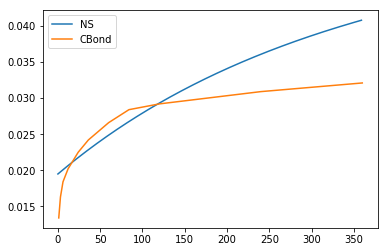

In [75]:
T_ = np.array([1/12,0.25,0.5,1,2,3,5,7,10,20,30])

plt.plot(TS.ps[-1:].as_matrix().flatten(),label='NS')
plt.plot(T_*12,data_[-1:].as_matrix().flatten(),label='CBond')
plt.legend()

# Vasicek class: solve for model coeficients

Vasicek's model parameters can be solved by minimzing the loss function:

\begin{equation}
loss = \sum{\frac{1}{N}(P-P(0,T))^2} 
\end{equation}

The model for $P(0,T)$ is given by the following relations:

\begin{equation}
P(0,T) = A(T) exp^{-B(T)r_0}
\end{equation}
<br>
\begin{equation}
A(T) = exp{{\frac{(B(T)-T)(a^2b-\frac{\sigma^2}{2})}{a^2}}-\frac{\sigma^2B^2(T)}{4a}}
\end{equation}
<br>
\begin{equation}
B(T) = \frac{1-e^{-aT}}{a}
\end{equation}

The class Vasicek has this model implemented. It requires a time series with NelsonSiegel coeficients and the historical spot rates at a given set of maturities (ps). We use the method get_ps() on the previous cell to extract ps using NS.

In [45]:
class Vasicek():
    def __init__(self,NScoef,ps):
        self.t = np.array([1/12,0.25,0.5,1.0,2.0,3.0,5.0,7.0,10.0,20.0,30.0])
        self.NScoef = NScoef
        self.build_TS(NScoef)
        self.ps=ps
        self.sigma = np.std(ps)*np.sqrt(252)
        
    def build_TS(self,NScoef):
        t = self.t
        Nsiegel = NelsonSiegel(t)
        result = []
        for i in range(len(NScoef)):
            result.append(Nsiegel.NS(NScoef[i]))
        self.X = np.vstack(result)
        pass
    
    def Bt(self,t):
        a = self.a
        return 1-np.exp(-a*self.t)/a
    
    def get_AB(self):
        sigma = self.sigma
        x = self.t
        a = self.a
        b = self.b
        B = self.Bt(x)
        A = np.exp(((B-x)*(a**2*b-(sigma**2)/2))/a**2-(sigma**2*B**2)/(4*a))
        self.B=B
        self.A=A
        pass
    
    def get_P(self,r):
        A = self.A
        B = self.B
        b = np.exp(-np.multiply(B,r))
        return np.multiply(A,b)
    
    def loss(self,x):
        self.a = x[0]
        self.b = x[1]
        self.get_AB()
        sim_p = pd.DataFrame(self.X).apply(self.get_P,axis=1)
        p = 100/(self.ps+1)**self.t
        loss = np.array(p)-np.array(sim_p)
        size = loss.shape
        N = size[0]*size[1]
        loss = np.sum(loss**2)/N
        return loss
    
    def solve(self,x0=[1,1]):
        self.opt_results = optimize.minimize(self.loss,x0=x0,method='BFGS')
        self.a = self.opt_results.x[0]
        self.b = self.opt_results.x[1]
        print(self.opt_results)
    
    def price(self,T,r):
        dic = dict(zip(self.t,self.sigma))
        sigma = dic[T]
        a = self.a
        b = self.b
        B = 1-np.exp(-a*T)/a
        A = np.exp(((B-T)*(a**2*b-(sigma**2)/2))/a**2)-(sigma**2*B**2)/(4*a)
        return A*np.exp(-B*r)

    def rate(self,T,p):
        dic = dict(zip(self.t,self.sigma))
        sigma = dic[T]
        a = self.a
        b = self.b
        B = 1-np.exp(-a*T)/a
        A = np.exp(((B-T)*(a**2*b-(sigma**2)/2))/a**2)-(sigma**2*B**2)/(4*a)
        return -1*np.log(p/A)/B


In [46]:
V = Vasicek(TS.NScoef,TS.ps)
V.solve()

      fun: 5220.2423593841695
 hess_inv: array([[ 0.00549664, -0.01135545],
       [-0.01135545,  0.02419964]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 184
      nit: 22
     njev: 46
   status: 0
  success: True
        x: array([2.50706207, 8.11899077])


In [47]:
V.price(30,0.01)

-5.250495354502625e-05

Pending improvement: std rolling window, or period options. Way to do sensitivity analysis.